EL objetivo de este código es hacer una clase que genere la matriz de rigidez de un elemento con puntas rígidaz y luego comparar como influye el largo de estas en su matriz de rigidez. Para comparar la rigidez de los elementos, se utilizará la norma de la matriz de rigidez como una forma de medición.  La norma de una matriz proporciona una medida de su magnitud, lo que nos permite evaluar la rigidez global del sistema.  Al incrementar los desplazamientos rígidos (`dx` y `dy`), se espera que la norma de la matriz de rigidez aumente, indicando que el sistema se vuelve más rígido.


In [2]:
import numpy as np
import matplotlib.pyplot as plt

In [3]:
class BeamColumnElement:
    def __init__(self, coord_inicial, coord_final, E, A, I, dx=0, dy=0, printSummary=True):
        """
        Inicializa un elemento Beam-Column en 2D con 6 grados de libertad (3 por nodo).
        :param coord_inicial: Coordenadas del nodo inicial (x, y).
        :param coord_final: Coordenadas del nodo final (x, y).
        :param E: Módulo de elasticidad del material.
        :param A: Área de la sección transversal.
        :param I: Momento de inercia de la sección transversal.
        :param dx: Desplazamiento en X (rigidez axial).
        :param dy: Desplazamiento en Y (rigidez lateral).
        """
        self.coord_i = np.array(coord_inicial)  # Nodo inicial
        self.coord_f = np.array(coord_final)  # Nodo final
        self.E = E  # Módulo de elasticidad
        self.A = A  # Área de la sección transversal
        self.I = I  # Momento de inercia

        # Desplazamientos rígidos
        self.dx = dx
        self.dy = dy

        # Cálculo de geometría
        self.L, self.angle, self.R = self._geometria()

        # Cálculo de matrices de rigidez
        self.k_local = self._stiffness_matrix_local()
        self.Tlg = self._local_to_global_transformation()
        self.k_global = self._global_stiffness_matrix()
        self.Ts = self.transformationStiffnessMatrix()  # Matriz de transformación de rigidez

        # Desplazamientos corregidos (inicializado a None)
        self.u_corrected = None

        if printSummary:
            self.print_summary()

    def _geometria(self):
        """
        Calcula la longitud y el ángulo de orientación del elemento en el sistema global.
        También calcula la matriz de rotación R.
        """
        delta = self.coord_f - self.coord_i
        length_total = np.linalg.norm(delta)  # Longitud del elemento
        direction_unit = delta / length_total  # Vector unitario de dirección
        angle = np.arctan2(delta[1], delta[0])  # Ángulo de la viga

        # Matriz de rotación para transformar coordenadas locales a globales
        c = np.cos(angle)
        s = np.sin(angle)
        R = np.array([[c, -s], [s, c]])

        return length_total, angle, R

    def _stiffness_matrix_local(self):
        """
        Calcula la matriz de rigidez local para el elemento beam-column.
        """
        L = self.L
        A = self.A
        E = self.E
        I = self.I

        k_local = np.array([
            [ E * A / L,   0,              0,              -E * A / L,   0,              0],
            [ 0,            12 * E * I / L**3,   6 * E * I / L**2,    0,              -12 * E * I / L**3,  6 * E * I / L**2],
            [ 0,            6 * E * I / L**2,    4 * E * I / L,      0,              -6 * E * I / L**2,   2 * E * I / L],
            [-E * A / L,    0,              0,              E * A / L,    0,              0],
            [ 0,            -12 * E * I / L**3,  -6 * E * I / L**2,    0,              12 * E * I / L**3,   -6 * E * I / L**2],
            [ 0,            6 * E * I / L**2,    2 * E * I / L,      0,              -6 * E * I / L**2,   4 * E * I / L]
        ])

        return k_local

    def _local_to_global_transformation(self):
        """
        Calcula la matriz de transformación de coordenadas locales a globales.
        """
        c = np.cos(self.angle)
        s = np.sin(self.angle)

        Tlg = np.array([
            [ c, s, 0,  0, 0, 0],
            [-s, c, 0,  0, 0, 0],
            [ 0, 0, 1,  0, 0, 0],
            [ 0, 0, 0,  c, s, 0],
            [ 0, 0, 0, -s, c, 0],
            [ 0, 0, 0,  0, 0, 1]
        ])

        return Tlg

    def _global_stiffness_matrix(self):
        """
        Calcula la matriz de rigidez global aplicando la transformación.
        """
        k_global = self.Tlg.T @ self.k_local @ self.Tlg
        return k_global

    def transformationStiffnessMatrix(self):
        """
        Calcula la matriz de transformación de rigidez.
        """
        offset_i_local = np.array([self.dx, self.dy])     # Nodo i
        offset_j_local = np.array([-self.dx, self.dy])    # Nodo j (inverso en X local)

        # Transformación local → global
        offset_i_global = self.R @ offset_i_local
        offset_j_global = self.R @ offset_j_local

        Ts = np.array([
            [1, 0, -offset_i_global[1], 0, 0, 0],
            [0, 1, offset_i_global[0], 0, 0, 0],
            [0, 0, 1, 0, 0, 0],
            [0, 0, 0, 1, 0, -offset_j_global[1]],
            [0, 0, 0, 0, 1, offset_j_global[0]],
            [0, 0, 0, 0, 0, 1]
        ])

        return Ts

    def _extractDisplacements(self, u):
        """
        Extrae los desplazamientos globales, locales y básicos a partir de un vector de desplazamientos globales.
        """
        u_global = u
        u_local = self.Tlg @ u_global
        u_basic = u_local[:6]  # Asumimos 6 grados de libertad por nodo

        # Calculamos los desplazamientos corregidos
        xi_def = u_basic[0] + self.coord_i[0]
        yi_def = u_basic[1] + self.coord_i[1]
        xf_def = u_basic[3] + self.coord_f[0]
        yf_def = u_basic[4] + self.coord_f[1]

        self.u_corrected = np.array([[xi_def, yi_def], [xf_def, yf_def]])

        return u_global, u_local, u_basic

    def forceRecorvery(self, u):
        """
        Realiza la recuperación de las fuerzas internas basadas en los desplazamientos dados.
        """
        _, u_local, _ = self._extractDisplacements(u)
        f_local = self.k_local @ u_local
        self.f_local = f_local
        print(f"Fuerzas locales recuperadas: {f_local}")

    def print_summary(self):
        """
        Imprime un resumen con la información relevante del elemento beam-column.
        """
        print(f"Coordenadas: {self.coord_i} -> {self.coord_f}")
        print(f"Longitud: {self.L}")
        print(f"Ángulo: {self.angle}")
        print(f"Material Properties: E={self.E}, A={self.A}, I={self.I}")
        print(f"Matriz de rigidez local (k_local): \n{self.k_local}")
        print(f"Matriz de rigidez global (k_global): \n{self.k_global}")

    def plotGeometry(self, text=False, nodes=True, nodes_labels=False, escala=10):
        """
        Dibuja la ubicación del nodo en un gráfico con deformaciones escaladas.
        :param escala: Factor para escalar las deformaciones y hacerlas más visibles.
        """
        xi_real, yi_real = self.coord_i
        xf_real, yf_real = self.coord_f

        fig, ax = plt.subplots(figsize=(12, 8))  # Tamaño de la figura ajustado
        
        # Escalar la viga original (eje total)
        xi_real_scaled = xi_real * escala
        yi_real_scaled = yi_real * escala
        xf_real_scaled = xf_real * escala
        yf_real_scaled = yf_real * escala

        ax.plot([xi_real_scaled, xf_real_scaled], [yi_real_scaled, yf_real_scaled], 
                'k--', linewidth=1, label=f'Eje total (x{escala})')

        # Escalar las coordenadas deformadas
        if self.u_corrected is not None:
            xi_def, yi_def = self.u_corrected[0]  # Coordenada deformada del nodo i
            xf_def, yf_def = self.u_corrected[1]  # Coordenada deformada del nodo f
            
            # Multiplicar las coordenadas deformadas por el factor de escala
            xi_def_scaled = xi_def * escala
            yi_def_scaled = yi_def * escala
            xf_def_scaled = xf_def * escala
            yf_def_scaled = yf_def * escala
            
            # Asegurarse de que no haya desplazamiento en X si no hay deformación en X
            xi_def_scaled = 0 if xi_def == 0 else xi_def_scaled
            xf_def_scaled = 0 if xf_def == 0 else xf_def_scaled
            
            # Sumar las deformaciones escaladas a las coordenadas originales
            ax.plot([xi_real + xi_def_scaled, xf_real + xf_def_scaled], 
                    [yi_real + yi_def_scaled, yf_real + yf_def_scaled], 'r--', linewidth=2, label=f'Deformada (x{escala})')

        if nodes:
            ax.plot(xi_real_scaled, yi_real_scaled, 'ro')  # Nodo inicial escalado
            ax.plot(xf_real_scaled, yf_real_scaled, 'ro')  # Nodo final escalado

        if nodes_labels:
            ax.text(xi_real, yi_real, f"i ({xi_real:.2f}, {yi_real:.2f})", fontsize=9, ha='right', va='bottom')
            ax.text(xf_real, yf_real, f"f ({xf_real:.2f}, {yf_real:.2f})", fontsize=9, ha='left', va='top')

        # Ajustar los límites del eje Y para que siempre se vea de -10 a 10
        ax.set_ylim(-10, 10)

        ax.set_aspect('equal')
        ax.set_xlabel('X (m)')
        ax.set_ylabel('Y (m)')
        ax.grid(True)
        ax.legend(loc='center left', bbox_to_anchor=(1.02, 0.5), borderaxespad=0)

        plt.show()


Coordenadas: [0 0] -> [5 0]
Longitud: 5.0
Ángulo: 0.0
Material Properties: E=24870.062324007155, A=0.09, I=0.0006749999999999999
Matriz de rigidez local (k_local): 
[[ 447.66112183    0.            0.         -447.66112183    0.
     0.        ]
 [   0.            1.61158004    4.0289501     0.           -1.61158004
     4.0289501 ]
 [   0.            4.0289501    13.42983365    0.           -4.0289501
     6.71491683]
 [-447.66112183    0.            0.          447.66112183    0.
     0.        ]
 [   0.           -1.61158004   -4.0289501     0.            1.61158004
    -4.0289501 ]
 [   0.            4.0289501     6.71491683    0.           -4.0289501
    13.42983365]]
Matriz de rigidez global (k_global): 
[[ 447.66112183    0.            0.         -447.66112183    0.
     0.        ]
 [   0.            1.61158004    4.0289501     0.           -1.61158004
     4.0289501 ]
 [   0.            4.0289501    13.42983365    0.           -4.0289501
     6.71491683]
 [-447.66112183    0. 

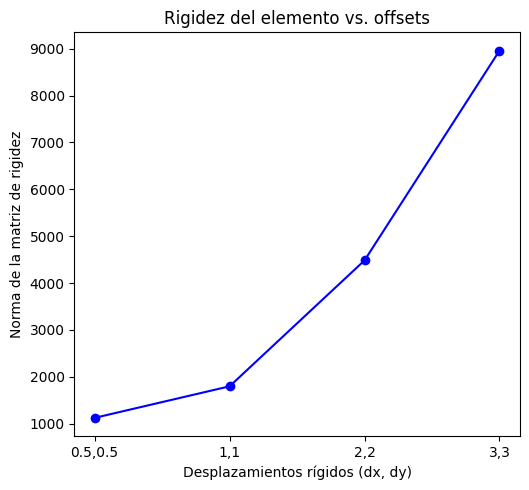

In [4]:
fc = 28  
E = 4700 * (fc**0.5)  
A = 0.3 * 0.3  
I = 0.3 ** 4 / 12  

coord_i = [0, 0]  
coord_f = [5, 0]  

u = np.array([0, 1, 0, 0, 0, 0])  

offsets = [(0.5, 0.5), (1, 1), (2, 2), (3, 3)]  

rigidity = []  
forces = []  

for dx, dy in offsets:
    beam = BeamColumnElement(coord_inicial=coord_i, coord_final=coord_f, E=E, A=A, I=I, dx=dx, dy=dy)
    K = beam.Ts.T @ beam.k_global @ beam.Ts
    F = K @ u
    rigidity.append(np.linalg.norm(K))  
    forces.append(np.linalg.norm(F))  
    beam.forceRecorvery(u)

plt.figure(figsize=(10, 5))

plt.subplot(1, 2, 1)
plt.plot([f"{dx},{dy}" for dx, dy in offsets], rigidity, marker='o', linestyle='-', color='b')
plt.title("Rigidez del elemento vs. offsets")
plt.xlabel("Desplazamientos rígidos (dx, dy)")
plt.ylabel("Norma de la matriz de rigidez")

plt.tight_layout()
plt.show()


El gráfico muestra cómo la norma de la matriz de rigidez global aumenta con el incremento de los desplazamientos rígidos (`dx` y `dy`). 
Esto indica que, al aumentar los desplazamientos rígidos, el elemento se vuelve más rígido, ya que introduce restricciones adicionales en los nodos, 
reduciendo su capacidad de deformarse bajo carga.